Created by: Emmanuel Castillo [ecastillot@unal.edu.co]

Running in Google Collab... 

# Montaje del disco Drive


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ahora vamos a descargar el repositorio, para tener acceso a la carpeta dataset. 

**Si ya lo descargamos omitamos esta linea.**

In [2]:
! git clone https://github.com/ecastillot/Seismology_IA.git /content/drive/MyDrive/Seismology_IA

Cloning into '/content/drive/MyDrive/Seismology_IA'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 5), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (26/26), done.


Comprobamos que si haya descargado

In [3]:
! ls -la /content/drive/MyDrive/Seismology_IA

total 1040
-rw------- 1 root root 526213 Apr 14 23:01 AI2class.ipynb
-rw------- 1 root root 525368 Apr 14 23:01 AI.ipynb
drwx------ 2 root root   4096 Apr 14 23:01 dataset
drwx------ 8 root root   4096 Apr 14 23:01 .git
drwx------ 2 root root   4096 Apr 14 23:01 .ipynb_checkpoints


Debe verse una carpeta llamada dataset.

# Introducción al Machine Learning

1. Carga de datos
2. Regresión logística (perceptrón)
3. Red Neuronal (perceptrón multicapa)
4. Red Neuronal Convolucional


## 1. Carga de datos

Referencia: https://github.com/martijnende/ICTP_EQ_tutorials/blob/master/ML/3_event_detection_answers.ipynb

In [1]:
# Import the libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import pickle

def load_data(dataset_folder):
    with gzip.GzipFile(f"{dataset_folder}/AE_data.tar.gz", "r") as f:
        data = pickle.load(f)
    return data["train_data"], data["train_labels"], data["test_data"], data["test_labels"]

dataset_folder = "/content/drive/MyDrive/Seismology_IA/dataset"
# Load the dataset
train_signals, train_labels, test_signals, test_labels = load_data(dataset_folder)
classes = {'1':"earthquake",'0':"noise"}

### Exploración de datos

In [16]:
m_train = train_signals.shape[0]
m_test = test_signals.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("train_signals shape: " + str(train_signals.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_signals shape: " + str(test_signals.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: 1440
Number of testing examples: 360
train_signals shape: (1440, 1024)
train_labels shape: (1440,)
test_signals shape: (360, 1024)
test_labels shape: (360,)


y = 1 --> earthquake


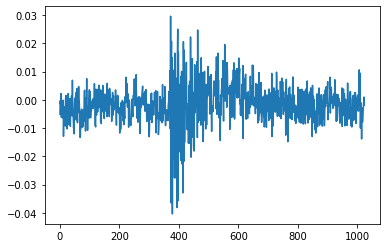

In [17]:
index = 37
plt.plot(train_signals[index,:])
print ("y = " + str(train_labels[index]) + " --> " + classes[str(train_labels[index] )])

## 2. Una neurona-Perceptrón

<p align="center"><img src="https://drive.google.com/uc?id=1IAGokghb1uFh8WK04i4tZWMbExlEb7cH" title="reshape2vector" width="500" align="center" /></p> 

In [18]:
def detection_model(x_train,y_train,epochs):
    """
    Crea un modelo perceptrón

    Parametros
    ----------
    x_train: arreglo de numpy
      datos de entrenamiento (señal)
    y_train: arreglo de numpy
      Etiquetas de los datos de entrenamiento

    Resultado
    ---------
    model: Modelo de Tensorflow
      Modelo desarrollado para detectar sismos
    """
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid,input_shape=x_train[0].shape) )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x_train,y_train,epochs=epochs)
    return model

mymodel = detection_model(x_train=train_signals,y_train=train_labels,epochs=100)
mymodel.summary()

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4632
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5696
Epoch 3/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5612
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5629
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.5737
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5792
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5722
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.6036
Epoch 9/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.6008
Epoch 10/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.5854
Epoch 11/

Veamos que predice nuestro modelo evaluandolo en nuestros datos de predicción.

In [19]:
test_loss, test_acc = mymodel.evaluate(test_signals, test_labels)
print("Test accuracy: %.4f" % test_acc)

12/12 [==============================] - 0s 2ms/step - loss: 0.6832 - accuracy: 0.5472
Test accuracy: 0.5472


In [20]:
predictions = mymodel.predict(test_signals)
rounded_predictions = np.round(predictions).astype(int)

Reality: y = 0 --> noise
Prediction: y = 0 --> . Your single model prediction: noise


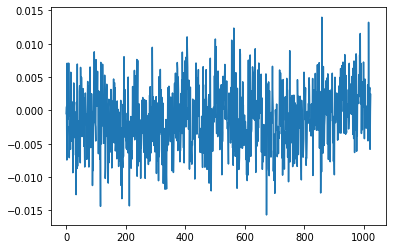

In [21]:
index = 40
plt.plot(test_signals[index,:])
print ("Reality: y = " + str(test_labels[index]) +\
    " --> " + classes[str(test_labels[index] )])
print ("Prediction: y = " + str(rounded_predictions[index][0]) +\
    " --> . Your single model prediction: " + classes[str(rounded_predictions[index][0] )])

para evaluar de manera general nuestro modelo hacemos lo siguiente:

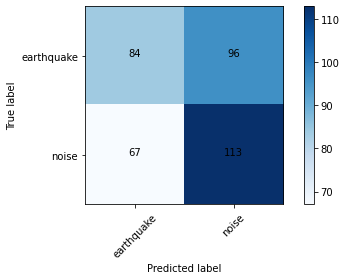

In [22]:
cm = confusion_matrix(y_true= test_labels, y_pred = np.squeeze(rounded_predictions))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
tick_marcks = np.arange((len(list(classes.values()))))
plt.xticks(tick_marcks,list(classes.values()),rotation=45)
plt.yticks(tick_marcks,list(classes.values()))

thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
  plt.text(j,i,cm[i,j],horizontalalignment="center",
           color="black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## 3. Red Neuronal densa

<p align="center"><img src="https://drive.google.com/uc?id=1ICjdnHl8Dk8Q3YzUZK6s4VZhBpZX9SDq" title="reshape2vector" width="500" align="center" /></p> 

In [11]:
def NN_detection_model(x_train,y_train,epochs):
    """
    Crea unA RED NEURONAL DENSA

    Parametros
    ----------
    x_train: arreglo de numpy
      datos de entrenamiento (señal)
    y_train: arreglo de numpy
      Etiquetas de los datos de entrenamiento

    Resultado
    ---------
    model: Modelo de Tensorflow
      Modelo desarrollado para detectar sismos
    """
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.Dense(units=4,activation=tf.nn.sigmoid,input_shape=x_train[0].shape) )
    model.add( tf.keras.layers.Dense(units=4,activation=tf.nn.sigmoid) )
    model.add( tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid) )
    model.add( tf.keras.layers.Dense(units=4,activation=tf.nn.sigmoid) )
    model.add( tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid) )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x_train,y_train,epochs=epochs)
    return model

NNmodel = NN_detection_model(x_train=train_signals,y_train=train_labels,epochs=100)
NNmodel.summary()

Epoch 1/100
45/45 [==============================] - 1s 2ms/step - loss: 0.7822 - accuracy: 0.5069
Epoch 2/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 0.5042
Epoch 3/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7428 - accuracy: 0.4955
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7252 - accuracy: 0.4986
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5015
Epoch 6/100
45/45 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.5037
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.4889
Epoch 8/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.4927
Epoch 9/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5007
Epoch 10/100
45/45 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5103
Epoch 11/

Veamos que predice nuestro modelo evaluandolo en nuestros datos de predicción.

In [12]:
test_loss, test_acc = NNmodel.evaluate(test_signals, test_labels)
print("Test accuracy: %.4f" % test_acc)

12/12 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5444
Test accuracy: 0.5444


In [13]:
NNpredictions = NNmodel.predict(test_signals)
NNrounded_predictions = np.round(NNpredictions).astype(int)

Reality: y = 1 --> earthquake
Prediction: y = 1 --> . Your single model prediction: earthquake


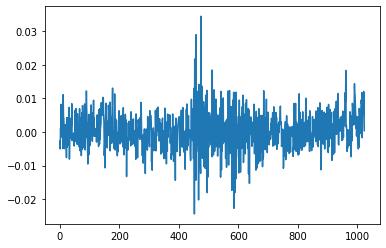

In [14]:
index = 20
plt.plot(test_signals[index,:])
print ("Reality: y = " + str(test_labels[index]) +\
    " --> " + classes[str(test_labels[index] )])
print ("Prediction: y = " + str(NNrounded_predictions[index][0]) +\
    " --> . Your single model prediction: " + classes[str(NNrounded_predictions[index][0] )])

para evaluar de manera general nuestro modelo hacemos lo siguiente:

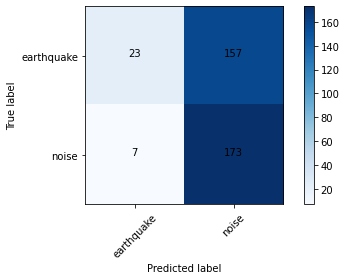

In [15]:
cm = confusion_matrix(y_true= test_labels, y_pred = np.squeeze(NNrounded_predictions))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
tick_marcks = np.arange((len(list(classes.values()))))
plt.xticks(tick_marcks,list(classes.values()),rotation=45)
plt.yticks(tick_marcks,list(classes.values()))

thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
  plt.text(j,i,cm[i,j],horizontalalignment="center",
           color="black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## 4. Convolutional Neural Network (CNN)
<p align="center"><img src="https://drive.google.com/uc?id=1ETJv6XkzA-CVNvA9SJEDZGSjBboF6jY7" title="cnn" width="500" align="center" /></p> 


In [2]:
def CNN_detection_model(x_train,y_train,epochs):
    """
    Crea unA RED NEURONAL Convolucional

    Parametros
    ----------
    x_train: arreglo de numpy
      datos de entrenamiento (señal)
    y_train: arreglo de numpy
      Etiquetas de los datos de entrenamiento

    Resultado
    ---------
    model: Modelo de Tensorflow
      Modelo desarrollado para detectar sismos
    """
    

    # Keras default initialiser = glorot_uniform
    # A better initialiser for ReLU activations = he_normal
    initializer = "he_normal"
    # initializer = "glorot_uniform"

    model = keras.Sequential([
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer, input_shape=x_train[0].shape),
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
        keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
        keras.layers.MaxPooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation=tf.nn.relu, kernel_initializer=initializer),
        keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer="glorot_normal")
    ])
    # Compile and print a summary
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(
        x_train, 
        y_train, 
        verbose=1,
        epochs=10)
    return model


# For convolutional layers, an additional dimension needs to be added
rs_train_signals = np.expand_dims(train_signals, 2)
rs_test_signals = np.expand_dims(test_signals, 2)
CNNmodel = CNN_detection_model(x_train=rs_train_signals,y_train=train_labels,epochs=100)

Epoch 1/10
45/45 [==============================] - 4s 68ms/step - loss: 0.6950 - accuracy: 0.5083
Epoch 2/10
45/45 [==============================] - 3s 66ms/step - loss: 0.6928 - accuracy: 0.5240
Epoch 3/10
45/45 [==============================] - 3s 68ms/step - loss: 0.6769 - accuracy: 0.6096
Epoch 4/10
45/45 [==============================] - 3s 67ms/step - loss: 0.6490 - accuracy: 0.7181
Epoch 5/10
45/45 [==============================] - 3s 66ms/step - loss: 0.6399 - accuracy: 0.7067
Epoch 6/10
45/45 [==============================] - 3s 69ms/step - loss: 0.5684 - accuracy: 0.7441
Epoch 7/10
45/45 [==============================] - 3s 67ms/step - loss: 0.5467 - accuracy: 0.7585
Epoch 8/10
45/45 [==============================] - 3s 67ms/step - loss: 0.5128 - accuracy: 0.7784
Epoch 9/10
45/45 [==============================] - 3s 67ms/step - loss: 0.4981 - accuracy: 0.7824
Epoch 10/10
45/45 [==============================] - 3s 67ms/step - loss: 0.4802 - accuracy: 0.7858


Evaluemos nuestro modelo en lso datos de testeo.

In [25]:
test_loss, test_acc = CNNmodel.evaluate(rs_test_signals, test_labels)
print("Test accuracy: %.4f" % test_acc)

12/12 [==============================] - 0s 19ms/step - loss: 0.5317 - accuracy: 0.7889
Test accuracy: 0.7889


In [7]:
CNNpredictions = CNNmodel.predict(rs_test_signals)
CNNrounded_predictions = np.round(CNNpredictions).astype(int)

Reality: y = 1 --> earthquake
Prediction: y = 1 --> . Your single model prediction: earthquake


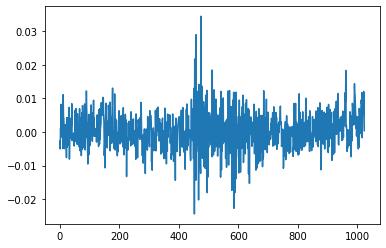

In [8]:
index = 20
plt.plot(test_signals[index,:])
print ("Reality: y = " + str(test_labels[index]) +\
    " --> " + classes[str(test_labels[index] )])
print ("Prediction: y = " + str(CNNrounded_predictions[index][0]) +\
    " --> . Your single model prediction: " + classes[str(CNNrounded_predictions[index][0] )])

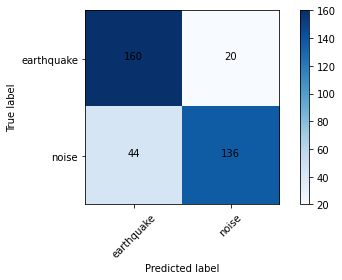

In [9]:
cm = confusion_matrix(y_true= test_labels, y_pred = np.squeeze(CNNrounded_predictions))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
tick_marcks = np.arange((len(list(classes.values()))))
plt.xticks(tick_marcks,list(classes.values()),rotation=45)
plt.yticks(tick_marcks,list(classes.values()))

thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
  plt.text(j,i,cm[i,j],horizontalalignment="center",
           color="black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

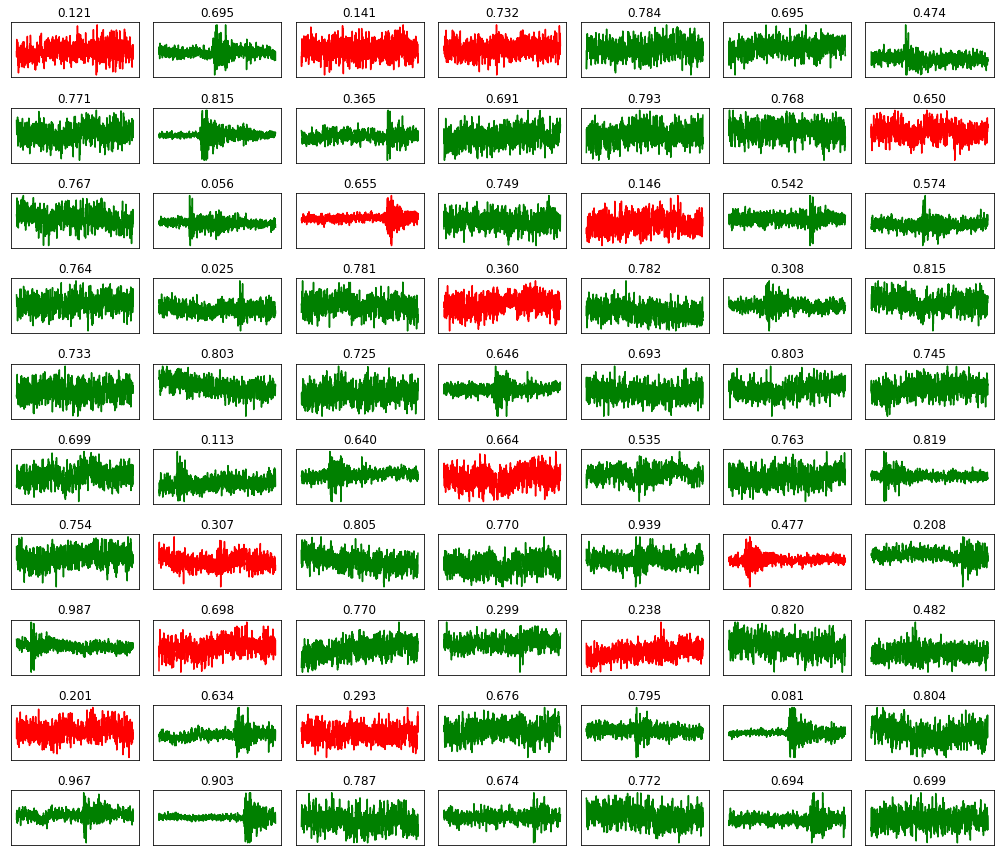

In [10]:
CNNpredictions = CNNmodel.predict(rs_test_signals)
confidence = 2 * np.abs(CNNpredictions - 0.5)
CNNpredictions = np.round(CNNpredictions).astype(int)


fig = plt.figure(figsize=(14, 12))

# Plot 70 examples of events and noise
for i in range(10):
    for j in range(7):
        n = 7*i + j
        # Events
        plt.subplot(10, 7, 1+n)
        if CNNpredictions[n] == test_labels[n]:
            colour = "g"
        else:
            colour = "r"
        plt.plot(test_signals[n], c=colour)
        plt.xticks([])
        plt.yticks([])
        plt.title("%.3f" % confidence[n])

plt.tight_layout()
plt.show()